# CS 733 Final Project: Dataset and CNNs
## Author: Elizabeth Trahadias
## Email: etrah001@odu.edu

This notebook collects some of our dataset and explores the class label distribution for our dataset. CNNs are trained to classify if the image is unhealthy or unhealthy. Additional CNNs are trained to classify the type of disease.

In [2]:
pip install session-info

  Using cached session_info-1.0.0-py3-none-any.whl
  Using cached stdlib_list-0.8.0-py3-none-any.whl (63 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import flickrapi
import xml.etree.ElementTree as ET
import urllib.request
import os
import csv
import json
import requests
import time
from requests import exceptions
import cv2
import argparse

In [4]:
import session_info
session_info.show()

In [2]:
# Set a random seed for reproducable results
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)

### Image Collection

For this project, I am created a custom data set from images found online. I will be using the Flickr API to collect some of my images.

References for image collection:
* https://www.flickr.com/services/api/flickr.photos.licenses.getInfo.html
* https://www.flickr.com/services/api/
* https://www.flickr.com/services/api/flickr.photos.search.html
* https://medium.com/codex/collecting-image-data-for-machine-learning-in-python-6334474d0e23
* https://towardsdatascience.com/how-to-use-flickr-api-to-collect-data-for-deep-learning-experiments-209b55a09628
* https://github.com/jeffheaton/pyimgdata/blob/main/flickr-download.py

#### Flickr Image Collection

In [3]:
### Please collect your own API keys
# flickr = flickrapi.FlickrAPI(api_key, api_secret)

In [4]:
def get_flickr_photos(picture_tags, directory_path, image_start, note):

    urls = []

    for picture in picture_tags:
        photos = flickr.walk(text=picture,
                             tag_mode='all',
                             tags=picture,
                             extras='url_c, license',
                             privacy_filters = 1,
                             license='0,7,8,9,10',
                             per_page=100,         
                             sort='relevance')

        for i, photo in enumerate(photos):
            # If unsuccessful, move to next image
            try:
                url = photo.get('url_c') # collect url
                license = photo.get('license') # collect image license
                Directory = directory_path # assign folder

                # Create a new folder if it does not exist already
                if not os.path.exists(Directory):
                    os.makedirs(Directory)

                # Create file path for image
                # Each image collected gets named one value higher
                # than the privious image
                filepath = os.path.join(Directory, f'{image_start}.jpg')
                image_start += 1

                # Download and save the image
                urllib.request.urlretrieve(url, filepath)
                urls.append([url, filepath, license, note])
                    
            except:
                pass
    
    # Write sources to CSV
    filename = os.path.join(Directory, 'Sources')
    with open(filename, 'a', newline='') as csvfile:  
        sources = csv.writer(csvfile)
        #sources.writerow(['url', 'file', 'license', 'note'])
        sources.writerows(urls)

Collect images for healthy frames. The words in the lists below are the tags we will use to find the relevant images.

In [5]:
healthy_bees = ['healthy bee brood', 'bee brood', 'bee brood', 'bee on comb', 'bee comb', 
                'bee honey comb', 'beehive, brood', 'bee, brood', 'capped brood, bee', 'uncapped brood, bee']

# Uncomment to collect photos
# get_flickr_photos(healthy_bees, 'BEES/Healthy', 1, "healthy")

Collect images for unhealthy frames. There were no pictures available for American Foulbrood, Parasitic Mite Syndrome, or chalkbrood.

In [6]:
clalkbrood = ['chalkbrood', 'chalkbrood, bees']

# get_flickr_photos(clalkbrood, 'BEES/Unhealthy', 292, 'chalkbrood')

In [7]:
efb = ['bee foulbrood', 'european foulbrood']

# get_flickr_photos(efb, 'BEES/Unhealthy', 304, 'efb')

Approximately 214 images were collected from Flickr. The functions to collect the images were commented out since our data set has already been collected.

### Import Images

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

### Classification Model to Distinguish Healthy vs Unhealthy

For the below, I followed the tutorial and documentation from [TensorFlow](https://www.tensorflow.org/tutorials/images/classification).

In [11]:
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [12]:
# Reduce the size of the images
batch_size = 32
img_height = 180
img_width = 180

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'BEES',
  validation_split=0.1,
  subset="training",
  seed=123,
  label_mode='binary',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 433 files belonging to 2 classes.
Using 390 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  'BEES',
  validation_split=0.1,
  subset="validation",
  seed=123,
  label_mode='binary',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 433 files belonging to 2 classes.
Using 43 files for validation.


In [15]:
# Load the testing data set
test_ds = tf.keras.utils.image_dataset_from_directory(
  'BEES_TEST',
  #validation_split=None,
  seed=123,
  label_mode='binary',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 50 files belonging to 2 classes.


/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


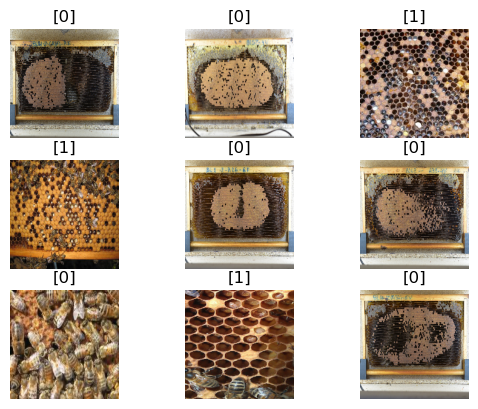

In [16]:
for images, labels in test_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy().astype("uint8"))
        plt.axis("off")

In [17]:
class_names = train_ds.class_names
print(class_names)

['Healthy', 'Unhealthy']


In [18]:
# Extract labels to view class distribution
train_labels=[]
for images, labels in train_ds.unbatch():
    train_labels.append(np.array(labels)[0])

val_labels=[]
for images, labels in val_ds.unbatch():
    val_labels.append(np.array(labels)[0])

In [19]:
test_labels=[]
for images, labels in test_ds.unbatch():
    test_labels.append(np.array(labels)[0])

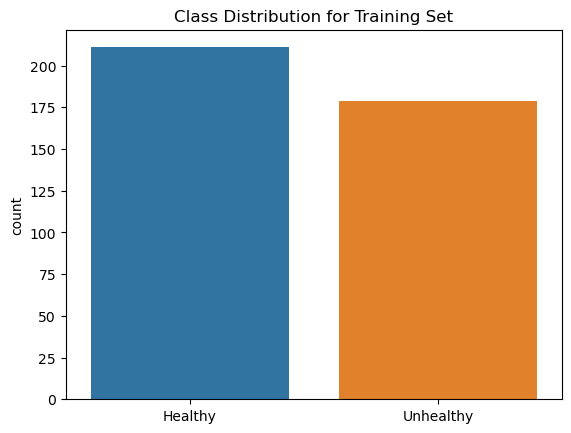

In [20]:
plt.title('Class Distribution for Training Set')
sns.countplot(x=train_labels)
plt.xticks([0,1], ['Healthy', 'Unhealthy'])
plt.show()

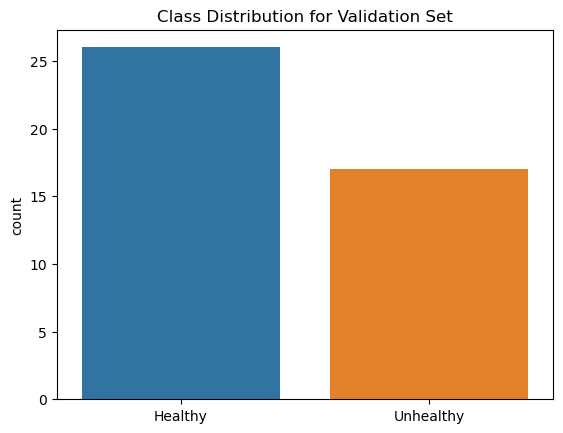

In [21]:
plt.title('Class Distribution for Validation Set')
sns.countplot(x=val_labels)
plt.xticks([0,1], ['Healthy', 'Unhealthy'])
plt.show()

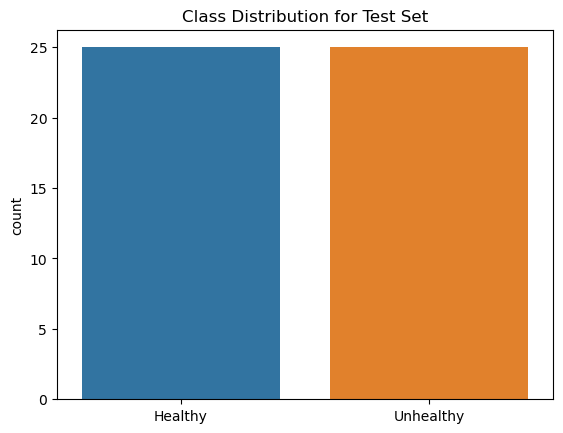

In [22]:
plt.title('Class Distribution for Test Set')
sns.countplot(x=test_labels)
plt.xticks([0,1], ['Healthy', 'Unhealthy'])
plt.show()

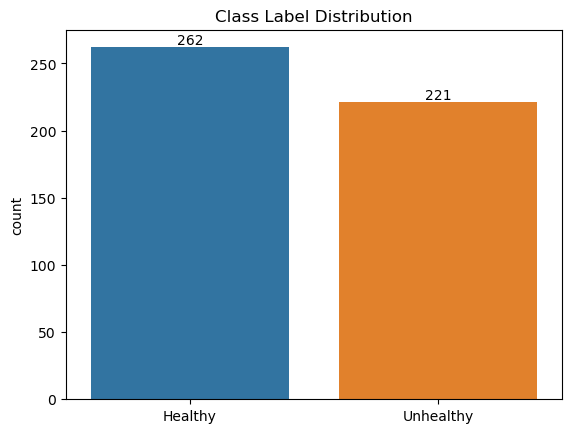

In [23]:
Total_Dist = train_labels + val_labels + test_labels

fig = sns.countplot(x=Total_Dist)
fig.bar_label(fig.containers[0])
plt.xticks([0,1], ['Healthy', 'Unhealthy'])
plt.title('Class Label Distribution')
plt.show()

In [24]:
N = len(train_labels) + len(val_labels) + len(test_labels)
n_unhealthy = sum(train_labels) + sum(val_labels) + sum(test_labels)
print("Proportion of unhealthy:", round(n_unhealthy/N, 2))
print("Number unhealthy:", n_unhealthy)
print("Number healthy:", N-n_unhealthy)

Proportion of unhealthy: 0.46
Number unhealthy: 221.0
Number healthy: 262.0


In [25]:
print("Proportion unhealthy (training):", round(sum(train_labels)/len(train_labels),2))
print("Proportion unhealthy (validation):",  round(sum(val_labels)/len(val_labels),2))
print("Proportion unhealthy (testing):", round(sum(test_labels)/len(test_labels),2))

Proportion unhealthy (training): 0.46
Proportion unhealthy (validation): 0.4
Proportion unhealthy (testing): 0.5


In [26]:
print("Training sample size:", len(train_labels))
print("Validation sample size:", len(val_labels))
print("Test sample size:", len(test_labels))
print("Total sample size:", len(train_labels) + len(val_labels) + len(test_labels))

Training sample size: 390
Validation sample size: 43
Test sample size: 50
Total sample size: 483


#### First CNN Model

In [27]:
# Create CNN model
# Source: https://www.tensorflow.org/tutorials/images/classification
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation = 'sigmoid')
])

In [28]:
from keras.callbacks import EarlyStopping

# Use early stopping to stop the model before it starts overfitting
callback = EarlyStopping(monitor='val_loss',
                                  mode='min',
                                  patience=3)

In [29]:
metrics = [keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[metrics])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

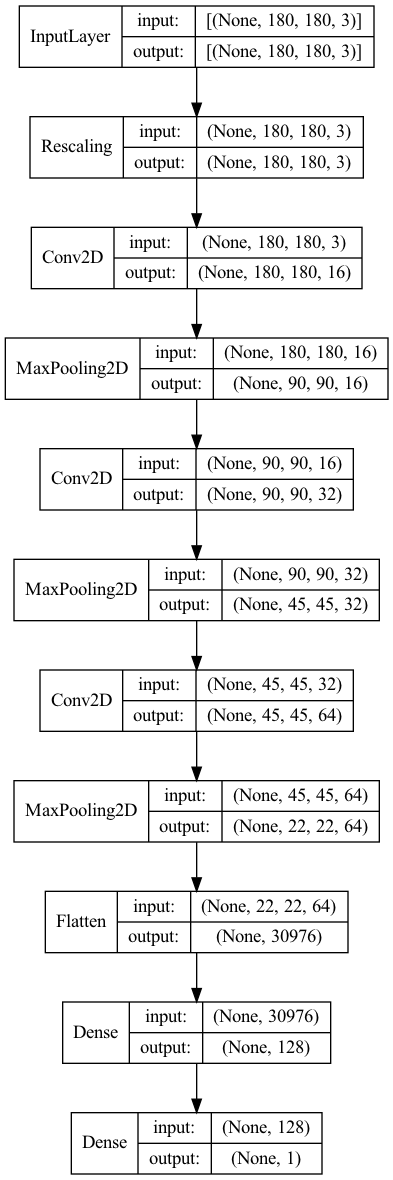

In [32]:
from tensorflow.keras.utils import plot_model

# https://pypi.org/project/plot-model/
plot_model(model, show_shapes=True, show_layer_names=False)

In [33]:
epochs=20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[callback])

Epoch 1/20


2022-12-15 17:30:18.314305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - ETA: 0s - loss: 0.8127 - binary_accuracy: 0.5154 - precision: 0.4830 - recall: 0.7933

2022-12-15 17:30:23.654968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 6s 180ms/step - loss: 0.8127 - binary_accuracy: 0.5154 - precision: 0.4830 - recall: 0.7933 - val_loss: 0.6938 - val_binary_accuracy: 0.3953 - val_precision: 0.3953 - val_recall: 1.0000
Epoch 2/20
13/13 [==============================] - 6s 154ms/step - loss: 0.6175 - binary_accuracy: 0.6974 - precision: 0.6344 - recall: 0.8045 - val_loss: 0.5471 - val_binary_accuracy: 0.7674 - val_precision: 1.0000 - val_recall: 0.4118
Epoch 3/20
13/13 [==============================] - 5s 154ms/step - loss: 0.5140 - binary_accuracy: 0.7513 - precision: 0.7733 - recall: 0.6480 - val_loss: 0.8403 - val_binary_accuracy: 0.6512 - val_precision: 0.5333 - val_recall: 0.9412
Epoch 4/20
13/13 [==============================] - 6s 154ms/step - loss: 0.4880 - binary_accuracy: 0.7846 - precision: 0.7950 - recall: 0.7151 - val_loss: 0.3827 - val_binary_accuracy: 0.8372 - val_precision: 0.7778 - val_recall: 0.8235
Epoch 5/20
13/13 [==============================] - 6s 155m

In [34]:
# View the Training and Validation Accuracy
def AccLossChart():
    plt.figure(figsize=(8, 4.5))
    plt.subplot(1, 2, 1)
    plt.title("Accuracy vs Number of Epochs")
    losses = pd.DataFrame(history.history)
    plt.plot(losses['binary_accuracy'], label='Training Accuracy')
    plt.plot(losses['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0.4,1)
    plt.legend(loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.title("Loss for Training and Validation")
    losses = pd.DataFrame(history.history)
    plt.plot(losses['loss'], label='Training Loss')
    plt.plot(losses['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

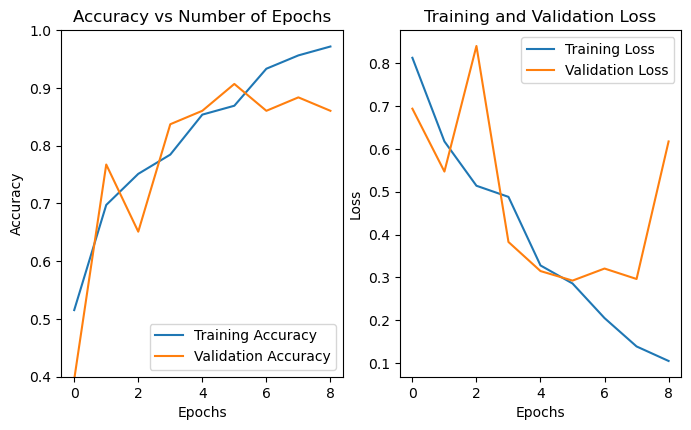

In [35]:
AccLossChart()

In [36]:
model.evaluate(val_ds, verbose=2)

2/2 - 1s - loss: 0.6174 - binary_accuracy: 0.8605 - precision: 0.7619 - recall: 0.9412 - 650ms/epoch - 325ms/step


[0.6173984408378601, 0.8604651093482971, 0.761904776096344, 0.9411764740943909]

In [37]:
model.evaluate(test_ds, verbose=2)

2/2 - 3s - loss: 0.3830 - binary_accuracy: 0.8600 - precision: 0.8462 - recall: 0.8800 - 3s/epoch - 1s/step


[0.38304588198661804, 0.85999995470047, 0.8461538553237915, 0.8799999952316284]

In [38]:
# Try out the test set
test_labels=[]
y_prob = []

for images, labels in test_ds.unbatch():
    test_labels.append(np.array(labels)[0])
    img_array = tf.keras.utils.img_to_array(images)
    img_array = tf.expand_dims(img_array, 0)
    y_prob.append(model.predict(img_array))

# Convert prediction probabilities into integers/labels
y_pred = np.array([1 if x >= 0.5 else 0 for x in y_prob])

from sklearn.metrics import classification_report
CNN1=classification_report(test_labels, y_pred, target_names=class_names, output_dict=True)
print(classification_report(test_labels, y_pred, target_names=class_names))

1/1 [==============================] - 0s 9ms/step


2022-12-15 17:31:14.814460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

     Healthy       0.88      0.84      0.86        25
   Unhealthy       0.85      0.88      0.86        25

    accuracy                           0.86        50
   macro avg       0.86      0.86      0.86        50
weighted avg       0.86      0.86      0.86        50



There appears to be some overfitting. Since we have a smaller data set, I will try augmenting the data and adding some drop out layers.

The functions below allow us to do a spot check on our models. The functions load in the images, make a prediction, and then show the image.

In [39]:
def MakePredictionsBinary(image_path, img_height, img_width):
    img = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    #Make predictions
    y_prob = model.predict(img_array)
    
    #Convert prediction probabilities into integers
    y_pred = [1 if x >= 0.5 else 0 for x in y_prob]
    
    return(
        "Probability is {}, and this image likely belongs to class {}".format(y_prob, y_pred), plt.imshow(img)
    )

In [40]:
def MakePredictions(image_path, img_height, img_width):
    img = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    
    return(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(predictions)], 100 * np.max(predictions)), plt.imshow(img)
    )

I'm also curious to see how our model performs on a few sample test images.

1/1 [==============================] - 0s 9ms/step


('Probability is [[0.7483031]], and this image likely belongs to class [1]',
 <matplotlib.image.AxesImage at 0x2ceab31c0>)

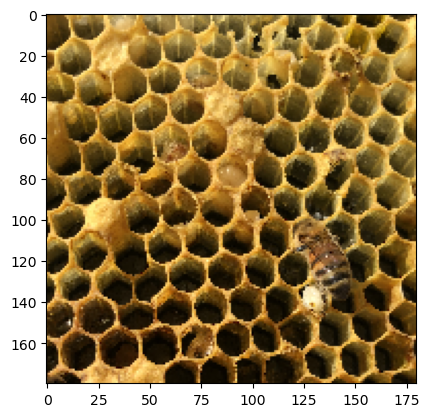

In [41]:
MakePredictionsBinary('my_bee_pics/test/unhealthy.jpeg', img_height, img_width)

1/1 [==============================] - 0s 9ms/step


('Probability is [[0.9997297]], and this image likely belongs to class [1]',
 <matplotlib.image.AxesImage at 0x2cec53be0>)

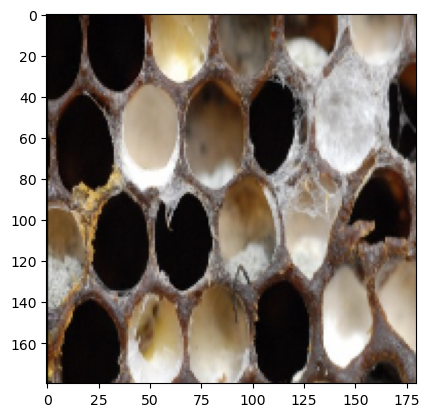

In [42]:
MakePredictionsBinary('my_bee_pics/test/stonebrood.jpeg', img_height, img_width)

1/1 [==============================] - 0s 9ms/step


('Probability is [[0.5595738]], and this image likely belongs to class [1]',
 <matplotlib.image.AxesImage at 0x2cecc9670>)

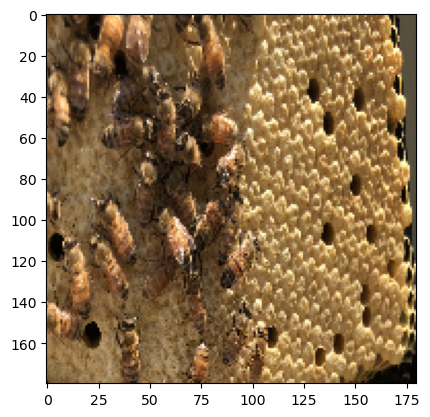

In [43]:
MakePredictionsBinary('my_bee_pics/test/healthy.jpeg', img_height, img_width)

2 out of 3 images were classified correctly. The first and the third images are from my beehives.

In [44]:
# Save this model
model.save('healthy_vs_unhealthy.h5')

In [45]:
# Recreate the model
# new_model = tf.keras.models.load_model('healthy_vs_unhealthy.h5')

### Data Augmentation to Reduce Overfitting

For this CNN, we will try data augmentation. We add a layer to the CNN that augments the images by rotating them and zooming in. This is a technique used to reduce overfitting.

In [46]:
# Source: https://www.tensorflow.org/tutorials/images/classification
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal_and_vertical",
                                                        input_shape=(img_height,img_width,3)),
                                                        layers.RandomRotation(0.2),
                                                        layers.RandomZoom(0.2),
                                                        #layers.RandomContrast(0.1)
                                                        ])

In [47]:
# Create CNN model with data augmentation
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation = 'sigmoid')
])

In [48]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[metrics])

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [50]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[callback]
)

Epoch 1/20


2022-12-15 17:31:17.604827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - ETA: 0s - loss: 0.7171 - binary_accuracy: 0.5977 - precision: 0.5659 - recall: 0.5686

2022-12-15 17:31:23.716635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 7s 245ms/step - loss: 0.7171 - binary_accuracy: 0.5977 - precision: 0.5659 - recall: 0.5686 - val_loss: 0.6111 - val_binary_accuracy: 0.7442 - val_precision: 0.6500 - val_recall: 0.7647
Epoch 2/20
13/13 [==============================] - 6s 217ms/step - loss: 0.5721 - binary_accuracy: 0.6974 - precision: 0.7798 - recall: 0.4749 - val_loss: 0.9182 - val_binary_accuracy: 0.7209 - val_precision: 0.5862 - val_recall: 1.0000
Epoch 3/20
13/13 [==============================] - 6s 210ms/step - loss: 0.4909 - binary_accuracy: 0.7872 - precision: 0.7637 - recall: 0.7765 - val_loss: 0.5689 - val_binary_accuracy: 0.7907 - val_precision: 0.6818 - val_recall: 0.8824
Epoch 4/20
13/13 [==============================] - 6s 212ms/step - loss: 0.4082 - binary_accuracy: 0.8000 - precision: 0.8258 - recall: 0.7151 - val_loss: 0.4794 - val_binary_accuracy: 0.7907 - val_precision: 0.6818 - val_recall: 0.8824
Epoch 5/20
13/13 [==============================] - 6s 214m

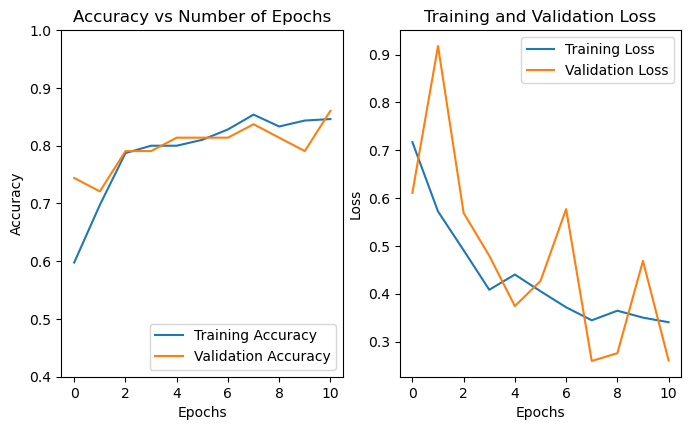

In [51]:
AccLossChart()

There performance, i.e. the accuracy, has decreased some; however, the model is not overfitting as much as before.

In [52]:
# https://www.tensorflow.org/tutorials/images/cnn
model.evaluate(val_ds, verbose=2)

2/2 - 1s - loss: 0.2603 - binary_accuracy: 0.8605 - precision: 0.8667 - recall: 0.7647 - 649ms/epoch - 324ms/step


[0.26034292578697205,
 0.8604651093482971,
 0.8666667342185974,
 0.7647058963775635]

In [53]:
model.evaluate(test_ds, verbose=2)

2/2 - 3s - loss: 0.3287 - binary_accuracy: 0.8800 - precision: 1.0000 - recall: 0.7600 - 3s/epoch - 1s/step


[0.3286662995815277, 0.8799999952316284, 1.0, 0.7599999904632568]

In [54]:
# Try out the test set
test_labels=[]
y_prob = []

for images, labels in test_ds.unbatch():
    test_labels.append(np.array(labels)[0])
    img_array = tf.keras.utils.img_to_array(images)
    img_array = tf.expand_dims(img_array, 0)
    y_prob.append(model.predict(img_array))

#Convert prediction probabilities into integers
y_pred = np.array([1 if x >= 0.5 else 0 for x in y_prob])

from sklearn.metrics import classification_report
CNN2=classification_report(test_labels, y_pred, target_names=class_names, output_dict=True)
print(classification_report(test_labels, y_pred, target_names=class_names))

1/1 [==============================] - 0s 10ms/step


2022-12-15 17:32:34.266111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

     Healthy       0.81      1.00      0.89        25
   Unhealthy       1.00      0.76      0.86        25

    accuracy                           0.88        50
   macro avg       0.90      0.88      0.88        50
weighted avg       0.90      0.88      0.88        50



1/1 [==============================] - 0s 8ms/step


('Probability is [[0.07180748]], and this image likely belongs to class [0]',
 <matplotlib.image.AxesImage at 0x16ea53e80>)

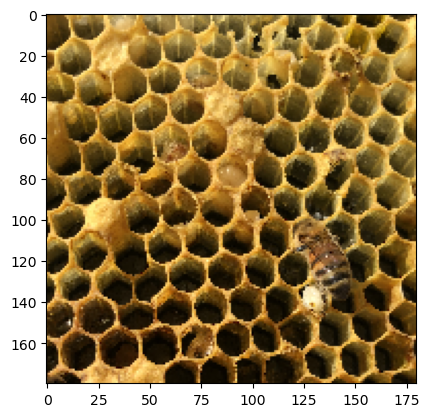

In [55]:
MakePredictionsBinary('my_bee_pics/test/unhealthy.jpeg', img_height, img_width)

1/1 [==============================] - 0s 9ms/step


('Probability is [[0.9290744]], and this image likely belongs to class [1]',
 <matplotlib.image.AxesImage at 0x2c8fba2b0>)

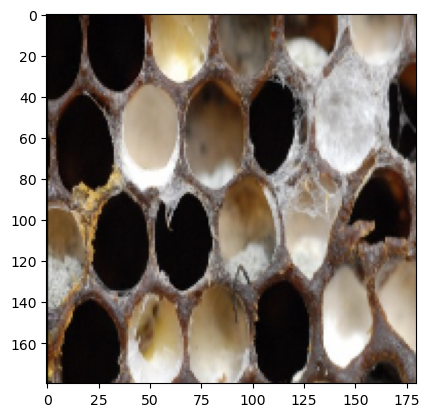

In [56]:
MakePredictionsBinary('my_bee_pics/test/stonebrood.jpeg', img_height, img_width)

1/1 [==============================] - 0s 9ms/step


('Probability is [[0.11640115]], and this image likely belongs to class [0]',
 <matplotlib.image.AxesImage at 0x2c9e37ca0>)

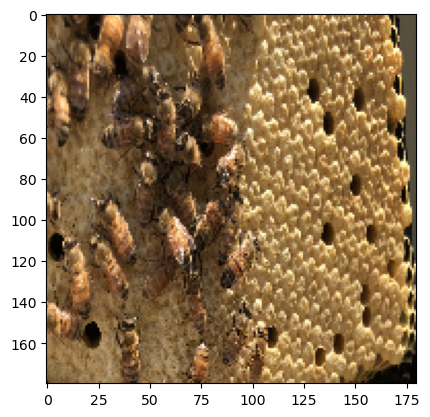

In [57]:
MakePredictionsBinary('my_bee_pics/test/healthy.jpeg', img_height, img_width)

In [58]:
model.save('CNN2_healthy_vs_unhealthy_final.h5')

### Dropout Layers to Prevent Overfitting

Dropout layers and data augmentation are often used together to reduce overfitting. Dropout layers randomly exclude some neurons from the hidden layer to improve the generalization of our model.

In [59]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Dropout(0.2), # Drop out layers
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

In [60]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[metrics])

In [61]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[callback])

Epoch 1/20


2022-12-15 17:32:36.893833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - ETA: 0s - loss: 0.7873 - binary_accuracy: 0.5545 - precision: 0.5238 - recall: 0.4314

2022-12-15 17:32:42.960683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 7s 239ms/step - loss: 0.7873 - binary_accuracy: 0.5545 - precision: 0.5238 - recall: 0.4314 - val_loss: 0.6400 - val_binary_accuracy: 0.7907 - val_precision: 0.6818 - val_recall: 0.8824
Epoch 2/20
13/13 [==============================] - 6s 215ms/step - loss: 0.5641 - binary_accuracy: 0.7846 - precision: 0.8519 - recall: 0.6425 - val_loss: 0.4200 - val_binary_accuracy: 0.8372 - val_precision: 0.7778 - val_recall: 0.8235
Epoch 3/20
13/13 [==============================] - 6s 216ms/step - loss: 0.4495 - binary_accuracy: 0.7821 - precision: 0.7975 - recall: 0.7039 - val_loss: 0.3554 - val_binary_accuracy: 0.8837 - val_precision: 0.7727 - val_recall: 1.0000
Epoch 4/20
13/13 [==============================] - 6s 209ms/step - loss: 0.4144 - binary_accuracy: 0.8179 - precision: 0.8253 - recall: 0.7654 - val_loss: 0.3399 - val_binary_accuracy: 0.8372 - val_precision: 0.8571 - val_recall: 0.7059
Epoch 5/20
13/13 [==============================] - 6s 216m

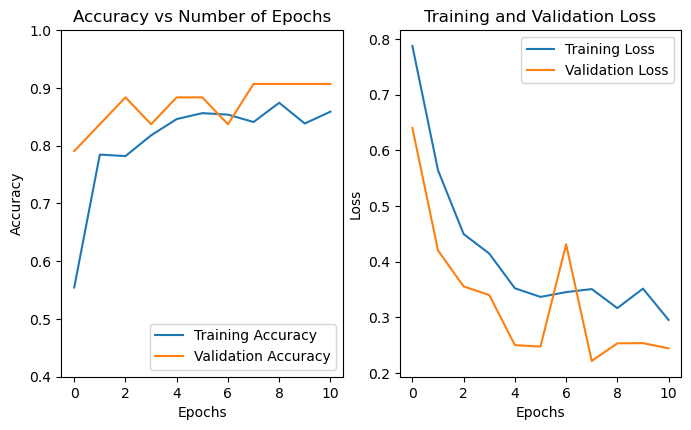

In [62]:
AccLossChart()

In [63]:
model.evaluate(test_ds, verbose=2)

2/2 - 3s - loss: 0.2576 - binary_accuracy: 0.9200 - precision: 1.0000 - recall: 0.8400 - 3s/epoch - 1s/step


[0.2575654089450836, 0.9199999570846558, 1.0, 0.8399999737739563]

In [64]:
# Try out the test set
test_labels=[]
y_prob = []

for images, labels in test_ds.unbatch():
    test_labels.append(np.array(labels)[0])
    img_array = tf.keras.utils.img_to_array(images)
    img_array = tf.expand_dims(img_array, 0)
    y_prob.append(model.predict(img_array))

#Convert prediction probabilities into integers
y_pred = np.array([1 if x >= 0.5 else 0 for x in y_prob])

from sklearn.metrics import classification_report
CNN3 = classification_report(test_labels, y_pred, target_names=class_names, output_dict=True)
print(classification_report(test_labels, y_pred, target_names=class_names))

1/1 [==============================] - 0s 10ms/step


2022-12-15 17:33:52.380151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

     Healthy       0.86      1.00      0.93        25
   Unhealthy       1.00      0.84      0.91        25

    accuracy                           0.92        50
   macro avg       0.93      0.92      0.92        50
weighted avg       0.93      0.92      0.92        50



1/1 [==============================] - 0s 9ms/step


('Probability is [[0.07795125]], and this image likely belongs to class [0]',
 <matplotlib.image.AxesImage at 0x2d7ce78e0>)

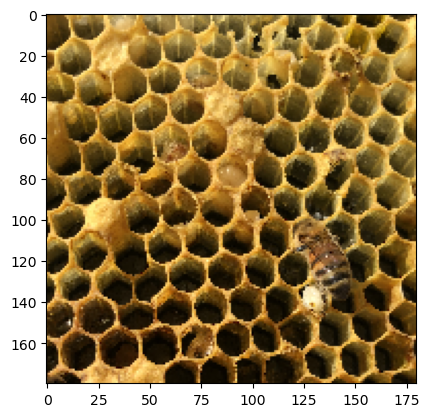

In [65]:
MakePredictionsBinary('my_bee_pics/test/unhealthy.jpeg', img_height, img_width)

1/1 [==============================] - 0s 9ms/step


('Probability is [[0.94219923]], and this image likely belongs to class [1]',
 <matplotlib.image.AxesImage at 0x2d7ee8190>)

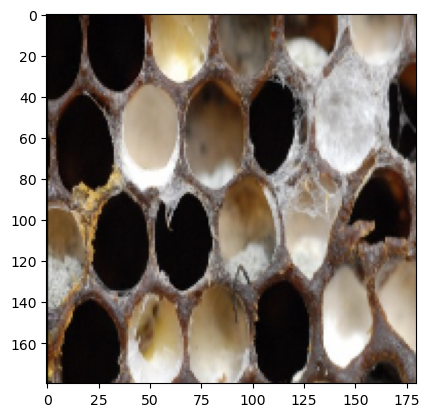

In [66]:
MakePredictionsBinary('my_bee_pics/test/stonebrood.jpeg', img_height, img_width)

1/1 [==============================] - 0s 9ms/step


('Probability is [[0.09930848]], and this image likely belongs to class [0]',
 <matplotlib.image.AxesImage at 0x2d7e0c0a0>)

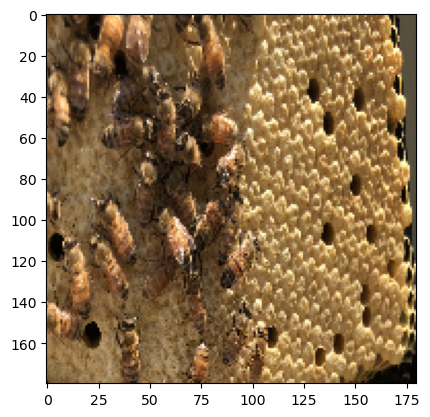

In [67]:
MakePredictionsBinary('my_bee_pics/test/healthy.jpeg', img_height, img_width)

This model produces relatively strong results. We can see that the accuracy is 92% and the F1-Score is 91%.

### Different CNN Architecture

In the model below, we will try a slightly different CNN architecture. Here, we will try more convolutoinal layers, and we will replace the `Flatten()` layer with the `GlobalMaxPooling2D()`. Source is [here](https://www.tensorflow.org/guide/keras/sequential_model).

In [68]:
### Different CNN Architecture

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # normalize pixels
    
  layers.Conv2D(32, (3,3), activation='relu'),
  layers.Conv2D(32, (3,3), activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Conv2D(32, (3,3), activation='relu'),
  layers.Conv2D(32, (3,3), activation='relu'),
  layers.Conv2D(32, (3,3), activation='relu'),
  layers.Dropout(0.2),
  layers.MaxPooling2D(),

  layers.GlobalMaxPooling2D(),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[metrics])

model.summary()

# Fit the model
epochs=20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[callback])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 conv2d_10 (Conv2D)          (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 88, 88, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 86, 86, 32)        9248      
                                                      

2022-12-15 17:33:55.171974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - ETA: 0s - loss: 0.6835 - binary_accuracy: 0.5818 - precision: 0.9545 - recall: 0.1029

2022-12-15 17:34:01.742250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 8s 278ms/step - loss: 0.6835 - binary_accuracy: 0.5818 - precision: 0.9545 - recall: 0.1029 - val_loss: 0.6616 - val_binary_accuracy: 0.6744 - val_precision: 1.0000 - val_recall: 0.1765
Epoch 2/20
13/13 [==============================] - 7s 249ms/step - loss: 0.6450 - binary_accuracy: 0.6410 - precision: 0.7532 - recall: 0.3240 - val_loss: 0.5842 - val_binary_accuracy: 0.7907 - val_precision: 0.7000 - val_recall: 0.8235
Epoch 3/20
13/13 [==============================] - 7s 244ms/step - loss: 0.5463 - binary_accuracy: 0.7590 - precision: 0.7640 - recall: 0.6872 - val_loss: 0.4458 - val_binary_accuracy: 0.8140 - val_precision: 0.7647 - val_recall: 0.7647
Epoch 4/20
13/13 [==============================] - 7s 247ms/step - loss: 0.5040 - binary_accuracy: 0.7795 - precision: 0.7627 - recall: 0.7542 - val_loss: 0.5443 - val_binary_accuracy: 0.7442 - val_precision: 0.6154 - val_recall: 0.9412
Epoch 5/20
13/13 [==============================] - 7s 241m

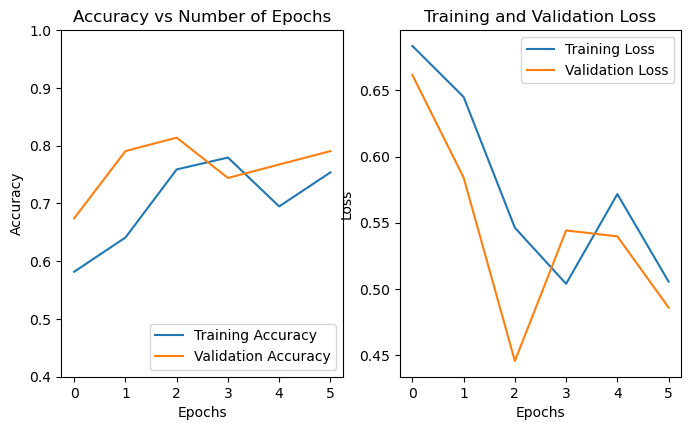

In [69]:
AccLossChart()

In [70]:
model.evaluate(test_ds, verbose=2)

2/2 - 3s - loss: 0.4516 - binary_accuracy: 0.8800 - precision: 0.8519 - recall: 0.9200 - 3s/epoch - 1s/step


[0.4516219198703766,
 0.8799999952316284,
 0.8518518805503845,
 0.9199999570846558]

In [71]:
# Try out the test set
test_labels=[]
y_prob = []
class_names = ['Healthy', 'Unhealthy']

for images, labels in test_ds.unbatch():
    test_labels.append(np.array(labels)[0])
    img_array = tf.keras.utils.img_to_array(images)
    img_array = tf.expand_dims(img_array, 0)
    y_prob.append(model.predict(img_array))

#Convert prediction probabilities into integers
y_pred = np.array([1 if x >= 0.5 else 0 for x in y_prob])

from sklearn.metrics import classification_report
CNN4 = classification_report(test_labels, y_pred, target_names=class_names, output_dict=True)
print(classification_report(test_labels, y_pred, target_names=class_names))

1/1 [==============================] - 0s 9ms/step


2022-12-15 17:34:42.301117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

     Healthy       0.91      0.84      0.87        25
   Unhealthy       0.85      0.92      0.88        25

    accuracy                           0.88        50
   macro avg       0.88      0.88      0.88        50
weighted avg       0.88      0.88      0.88        50



1/1 [==============================] - 0s 9ms/step


('Probability is [[0.81175125]], and this image likely belongs to class [1]',
 <matplotlib.image.AxesImage at 0x17cb33a00>)

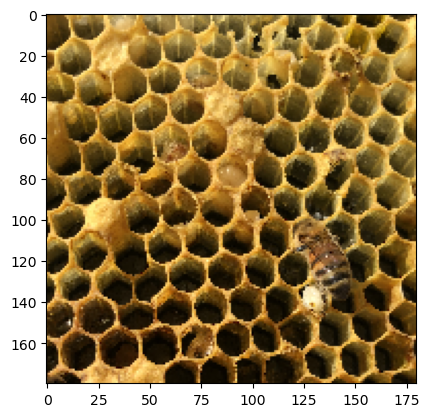

In [72]:
MakePredictionsBinary('my_bee_pics/test/unhealthy.jpeg', img_height, img_width)

1/1 [==============================] - 0s 9ms/step


('Probability is [[0.8760114]], and this image likely belongs to class [1]',
 <matplotlib.image.AxesImage at 0x2cf805130>)

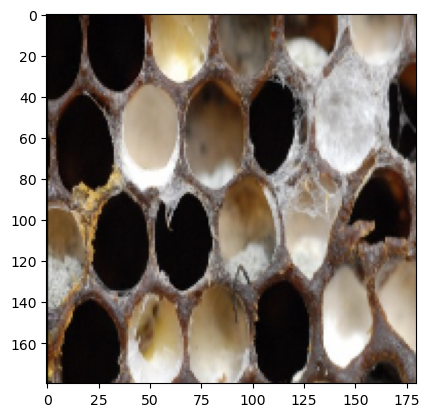

In [73]:
MakePredictionsBinary('my_bee_pics/test/stonebrood.jpeg', img_height, img_width)

1/1 [==============================] - 0s 8ms/step


('Probability is [[0.6163877]], and this image likely belongs to class [1]',
 <matplotlib.image.AxesImage at 0x2eb1a1b20>)

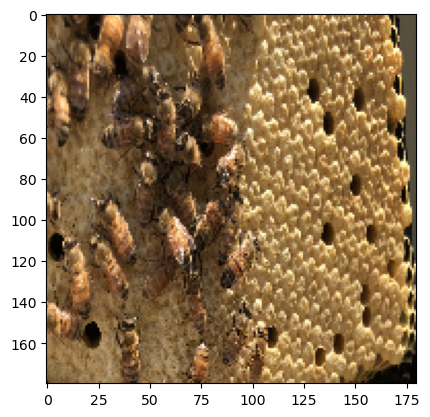

In [74]:
MakePredictionsBinary('my_bee_pics/test/healthy.jpeg', img_height, img_width)

In [75]:
model.save('CNN4_healthy_vs_unhealthy_final.h5')

### Transfer Learning and Fine-Tuning CNNs

In the function below, we will experiment with transfer learning and fine-tuning. In this task, we are using pre-trained models and adjusting the weights by training on some of our task-specific data. For each of the pre-trained models, we are freezing the final classification layer since we are only predicting if an image is healthy or unhealthy. Then, we are freezing a certain number of layers to use the pre-trained weights for those layers, and the non-frozen base layers will get fine-tuned. We have to put this all together into a model for our classification task, so we add an input layer, data augmentation layer, and a rescaling layer to start. Next, we add the base model (i.e. whatever pre-trained CNN the user calls in the function) and a dropout layer. Lastly, we add a Global Average Pooling layer to prepare the vector for the classification layer.

In [76]:
def TransferLearning(model_name):
    if model_name == 'VGG16':
        img_height, img_width = 224,224 
        base = tf.keras.applications.VGG16(input_shape = (224,224,3), 
                                     include_top=False,
                                     weights='imagenet')
    elif model_name == 'EfficientNet':
        img_height, img_width = 224,224 
        base = tf.keras.applications.EfficientNetB0(input_shape = (224,224,3), 
                                     include_top=False,
                                     weights='imagenet')
    else:
        img_height, img_width = 224,224
        base = tf.keras.applications.ResNet50(input_shape = (224,224,3), 
                                     include_top=False,
                                     weights='imagenet')

    base.trainable = True

    # Freeze all the layers before a certain layer
    for layer in base.layers[:(round(len(base.layers) * (2/3)))]:
        base.trainable = False

    base.summary()
    
    
    # Load the data sets with the resized images
    train_ds = tf.keras.utils.image_dataset_from_directory(
      'BEES',
      validation_split=0.1,
      subset="training",
      seed=123,
      label_mode='binary',
      image_size=(img_height, img_width),
      batch_size=batch_size)

    val_ds = tf.keras.utils.image_dataset_from_directory(
      'BEES',
      validation_split=0.1,
      subset="validation",
      seed=123,
      label_mode='binary',
      image_size=(img_height, img_width),
      batch_size=batch_size)

    test_ds = tf.keras.utils.image_dataset_from_directory(
      'BEES_TEST',
      #validation_split=0.1,
      #subset="training",
      seed=123,
      label_mode='binary',
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
    # Add a data augmentation layer
    data_augmentation = keras.Sequential([layers.RandomFlip("horizontal_and_vertical",
                                                        input_shape=(img_height,img_width,3)),
                                                        layers.RandomRotation(0.2),
                                                        layers.RandomZoom(0.2),
                                                        #layers.RandomContrast(0.1)
                                                        ])
    
    # Code inspiration: https://www.tensorflow.org/tutorials/images/transfer_learning
    resacle = tf.keras.layers.Rescaling(1./255.)
    glob_avg = tf.keras.layers.GlobalAveragePooling2D()
    prediction = tf.keras.layers.Dense(1, activation = 'sigmoid')
    
    inputs = tf.keras.Input(shape=(img_height,img_width,3))
    x = data_augmentation(inputs)
    x = resacle(x) # standardize pixels
    x = base(x) # pre-trained model
    x = tf.keras.layers.Dropout(0.2)(x) # dropout for overfitting
    x = glob_avg(x) # instead of flatten to turn into vector
    outputs = prediction(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model, train_ds, val_ds, test_ds

#### Transfer Learning with VGG-16

In [77]:
model, train_ds, val_ds, test_ds = TransferLearning('VGG16')

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [78]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                             

In [79]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[metrics])

In [80]:
epochs=20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[callback])

Epoch 1/20


2022-12-15 17:34:45.484721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - ETA: 0s - loss: 0.6987 - binary_accuracy: 0.5909 - precision: 0.5923 - recall: 0.3775

2022-12-15 17:34:54.507457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 11s 518ms/step - loss: 0.6987 - binary_accuracy: 0.5909 - precision: 0.5923 - recall: 0.3775 - val_loss: 0.6649 - val_binary_accuracy: 0.6744 - val_precision: 0.7143 - val_recall: 0.2941
Epoch 2/20
13/13 [==============================] - 9s 442ms/step - loss: 0.6465 - binary_accuracy: 0.6462 - precision: 0.8361 - recall: 0.2849 - val_loss: 0.6075 - val_binary_accuracy: 0.7907 - val_precision: 0.7857 - val_recall: 0.6471
Epoch 3/20
13/13 [==============================] - 9s 441ms/step - loss: 0.5972 - binary_accuracy: 0.7641 - precision: 0.8480 - recall: 0.5922 - val_loss: 0.5718 - val_binary_accuracy: 0.7907 - val_precision: 0.7500 - val_recall: 0.7059
Epoch 4/20
13/13 [==============================] - 9s 439ms/step - loss: 0.5644 - binary_accuracy: 0.7769 - precision: 0.8485 - recall: 0.6257 - val_loss: 0.5320 - val_binary_accuracy: 0.8140 - val_precision: 0.8000 - val_recall: 0.7059
Epoch 5/20
13/13 [==============================] - 9s 441

In [81]:
model.evaluate(test_ds, verbose = 2)

2/2 - 3s - loss: 0.3123 - binary_accuracy: 0.9000 - precision: 0.9545 - recall: 0.8400 - 3s/epoch - 2s/step


[0.31232964992523193,
 0.8999999761581421,
 0.9545454978942871,
 0.8399999737739563]

In [82]:
# Try out the test set
test_labels=[]
y_prob = []

for images, labels in test_ds.unbatch():
    test_labels.append(np.array(labels)[0])
    img_array = tf.keras.utils.img_to_array(images)
    img_array = tf.expand_dims(img_array, 0)
    y_prob.append(model.predict(img_array))

#Convert prediction probabilities into integers
y_pred = np.array([1 if x >= 0.5 else 0 for x in y_prob])

from sklearn.metrics import classification_report
CNN5 = classification_report(test_labels, y_pred, target_names=class_names, output_dict=True)
print(classification_report(test_labels, y_pred, target_names=class_names))

1/1 [==============================] - 0s 10ms/step


2022-12-15 17:37:57.849431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

     Healthy       0.86      0.96      0.91        25
   Unhealthy       0.95      0.84      0.89        25

    accuracy                           0.90        50
   macro avg       0.91      0.90      0.90        50
weighted avg       0.91      0.90      0.90        50



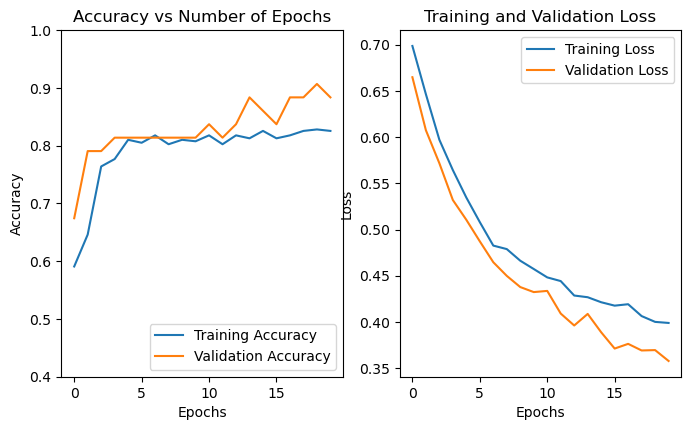

In [83]:
AccLossChart()

1/1 [==============================] - 0s 138ms/step


2022-12-15 17:37:59.820217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


('Probability is [[0.8950693]], and this image likely belongs to class [1]',
 <matplotlib.image.AxesImage at 0x17d3d65b0>)

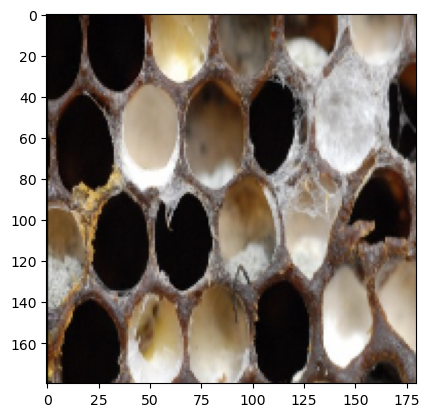

In [84]:
MakePredictionsBinary('my_bee_pics/test/stonebrood.jpeg', img_height, img_width)

1/1 [==============================] - 0s 14ms/step


('Probability is [[0.5830006]], and this image likely belongs to class [1]',
 <matplotlib.image.AxesImage at 0x17d467430>)

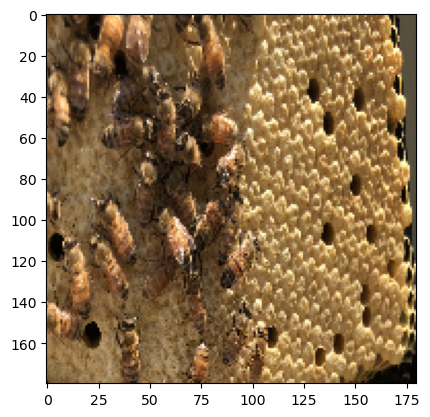

In [85]:
MakePredictionsBinary('my_bee_pics/test/healthy.jpeg', img_height, img_width)

In [86]:
# Save the best model
model.save('cnn_healthy_vs_unhealthy_final.h5')

#### Transfer Learning with ResNet-50

In [87]:
model, train_ds, val_ds, test_ds = TransferLearning('ResNet50')

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [88]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[metrics])

In [89]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_6 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [90]:
epochs=20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[callback])

Epoch 1/20


2022-12-15 17:38:04.056631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - ETA: 0s - loss: 0.6933 - binary_accuracy: 0.5818 - precision: 0.5450 - recall: 0.5931

2022-12-15 17:38:13.483769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 13s 470ms/step - loss: 0.6933 - binary_accuracy: 0.5818 - precision: 0.5450 - recall: 0.5931 - val_loss: 0.6405 - val_binary_accuracy: 0.7442 - val_precision: 0.8000 - val_recall: 0.4706
Epoch 2/20
13/13 [==============================] - 9s 354ms/step - loss: 0.6508 - binary_accuracy: 0.6333 - precision: 0.7432 - recall: 0.3073 - val_loss: 0.6358 - val_binary_accuracy: 0.7209 - val_precision: 0.6316 - val_recall: 0.7059
Epoch 3/20
13/13 [==============================] - 8s 337ms/step - loss: 0.6348 - binary_accuracy: 0.6795 - precision: 0.6709 - recall: 0.5922 - val_loss: 0.6207 - val_binary_accuracy: 0.7209 - val_precision: 0.6471 - val_recall: 0.6471
Epoch 4/20
13/13 [==============================] - 8s 332ms/step - loss: 0.6190 - binary_accuracy: 0.6513 - precision: 0.7009 - recall: 0.4190 - val_loss: 0.6159 - val_binary_accuracy: 0.7209 - val_precision: 0.6471 - val_recall: 0.6471
Epoch 5/20
13/13 [==============================] - 8s 331

In [91]:
model.evaluate(test_ds)

2/2 [==============================] - 3s 478ms/step - loss: 0.4929 - binary_accuracy: 0.8200 - precision: 0.9444 - recall: 0.6800


[0.4928821325302124, 0.8199999928474426, 0.944444477558136, 0.6800000071525574]

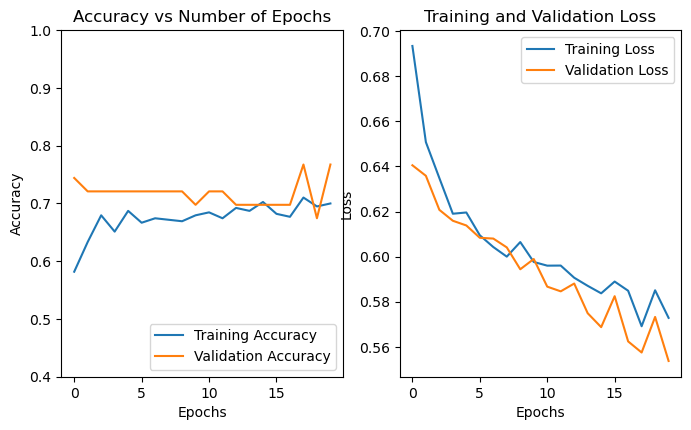

In [92]:
AccLossChart()

In [93]:
# Try out the test set
test_labels=[]
y_prob = []

for images, labels in test_ds.unbatch():
    test_labels.append(np.array(labels)[0])
    img_array = tf.keras.utils.img_to_array(images)
    img_array = tf.expand_dims(img_array, 0)
    y_prob.append(model.predict(img_array))

#Convert prediction probabilities into integers
y_pred = np.array([1 if x >= 0.5 else 0 for x in y_prob])

from sklearn.metrics import classification_report
CNN6 = classification_report(test_labels, y_pred, target_names=class_names, output_dict=True)
print(classification_report(test_labels, y_pred, target_names=class_names))

2022-12-15 17:40:55.946520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

     Healthy       0.75      0.96      0.84        25
   Unhealthy       0.94      0.68      0.79        25

    accuracy                           0.82        50
   macro avg       0.85      0.82      0.82        50
weighted avg       0.85      0.82      0.82        50



#### Transfer Learning with EfficientNet

In [94]:
model, train_ds, val_ds, test_ds = TransferLearning('EfficientNet')

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling_6[0][0]']            
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0

 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_e

 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )        

 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_s

 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_d

 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_e

 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
          

In [95]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[metrics])

In [96]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 1280)        0         
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [97]:
epochs=12
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  #callbacks=[callback]
)

Epoch 1/12


2022-12-15 17:41:04.185650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - ETA: 0s - loss: 0.7046 - binary_accuracy: 0.5136 - precision: 0.4709 - recall: 0.3971

2022-12-15 17:41:14.692294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 16s 624ms/step - loss: 0.7046 - binary_accuracy: 0.5136 - precision: 0.4709 - recall: 0.3971 - val_loss: 0.6710 - val_binary_accuracy: 0.6047 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/12
13/13 [==============================] - 9s 331ms/step - loss: 0.6922 - binary_accuracy: 0.5410 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6885 - val_binary_accuracy: 0.6047 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/12
13/13 [==============================] - 7s 284ms/step - loss: 0.6935 - binary_accuracy: 0.5103 - precision: 0.4732 - recall: 0.5922 - val_loss: 0.6776 - val_binary_accuracy: 0.6047 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/12
13/13 [==============================] - 7s 282ms/step - loss: 0.6906 - binary_accuracy: 0.5410 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6772 - val_binary_accuracy: 0.6047 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/12

In [98]:
model.evaluate(test_ds, verbose = True)

2/2 [==============================] - 4s 1s/step - loss: 0.7004 - binary_accuracy: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.7004263997077942, 0.5, 0.0, 0.0]

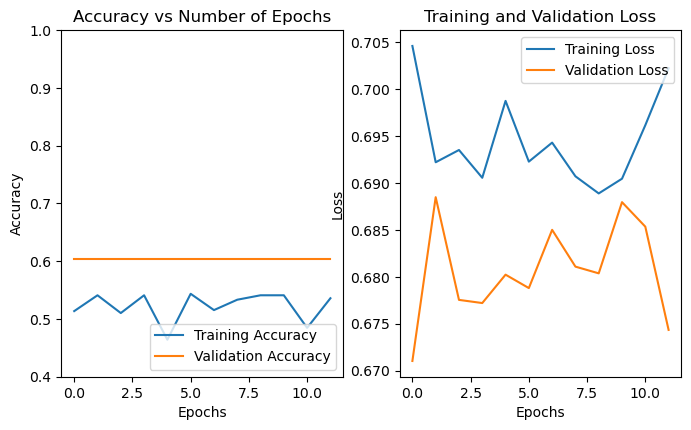

In [99]:
AccLossChart()

In [100]:
# Try out the test set
test_labels=[]
y_prob = []

for images, labels in test_ds.unbatch():
    test_labels.append(np.array(labels)[0])
    img_array = tf.keras.utils.img_to_array(images)
    img_array = tf.expand_dims(img_array, 0)
    y_prob.append(model.predict(img_array))

#Convert prediction probabilities into integers
y_pred = np.array([1 if x >= 0.5 else 0 for x in y_prob])

from sklearn.metrics import classification_report
CNN7 = classification_report(test_labels, y_pred, target_names=class_names, output_dict=True)
print(classification_report(test_labels, y_pred, target_names=class_names))

2022-12-15 17:42:48.568600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 25ms/step
              precision    recall  f1-score   support

     Healthy       0.50      1.00      0.67        25
   Unhealthy       0.00      0.00      0.00        25

    accuracy                           0.50        50
   macro avg       0.25      0.50      0.33        50
weighted avg       0.25      0.50      0.33        50



/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt

#### Compare CNN Results

In [101]:
def ResultsTable(dict_name, name, pos_neg_class):
    if pos_neg_class == "positive":
        results_df = pd.DataFrame(dict_name['Unhealthy'], index=[0]).T
    else:
        results_df = pd.DataFrame(dict_name['Healthy'], index=[0]).T
    y=pd.Series(dict_name['accuracy'])
    y.name='accuracy'
    results_df=pd.concat([results_df,y])
    results_df.rename({0:name}, axis=1, inplace=True)
    results_df.rename({0:'accuracy'}, axis=0, inplace=True)
    return(results_df)

In [102]:
CNN_positive_class = pd.concat([ResultsTable(CNN1, 'CNN1', 'positive'), 
          ResultsTable(CNN2, 'CNN2','positive'), 
          ResultsTable(CNN3, 'CNN3','positive'), ResultsTable(CNN4, 'CNN4','positive'), 
          ResultsTable(CNN5, 'CNN5','positive'),
          ResultsTable(CNN6, 'CNN6','positive'),
          ResultsTable(CNN7, 'CNN7','positive')], axis=1)

CNN_negative_class = pd.concat([ResultsTable(CNN1, 'CNN1', 'negative'), 
          ResultsTable(CNN2, 'CNN2','negative'), 
          ResultsTable(CNN3, 'CNN3','negative'), ResultsTable(CNN4, 'CNN4','negative'), 
          ResultsTable(CNN5, 'CNN5','negative'),
          ResultsTable(CNN6, 'CNN6','negative'),
          ResultsTable(CNN7, 'CNN7','negative')], axis=1)

In [103]:
CNN_positive_class.drop('support', axis=0, inplace=True)
CNN_negative_class.drop('support', axis=0, inplace=True)

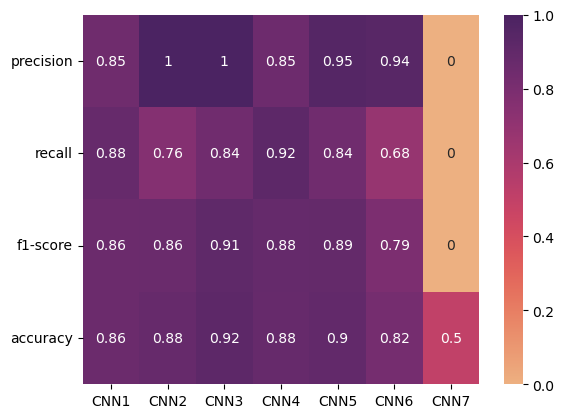

In [104]:
# Results on the test set (Unhealthy Class)
sns.heatmap(CNN_positive_class, annot=True, cmap="flare")
plt.yticks(rotation=0)
plt.show()

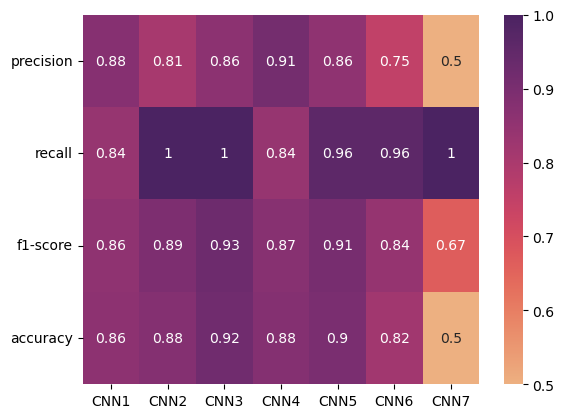

In [105]:
# Results on the test set (Healthy Class)
sns.heatmap(CNN_negative_class, annot=True, cmap="flare")
plt.yticks(rotation=0)
plt.show()

CNN5 seems to have the best performance. We will save this model for future use in our model pipeline.

### CNN for Just Unhealthy Images

Now that we have a model that is able to distinguish between healthy frames and unhealthy frames, let's try predicting the type of disease.

In [106]:
df = pd.read_csv("BEES/Sources_captions.csv")
df

url  \
0    https://live.staticflickr.com/7466/27401150176...   
1    https://live.staticflickr.com/7387/27435735775...   
2    https://live.staticflickr.com/8681/16200799428...   
3    https://live.staticflickr.com/7316/27030739643...   
4    https://live.staticflickr.com/7296/16387517262...   
..                                                 ...   
191  https://afb.org.nz/wp-content/uploads/2019/08/...   
192  https://afb.org.nz/wp-content/uploads/2019/08/...   
193  https://afb.org.nz/wp-content/uploads/2021/09/...   
194  https://beeaware.org.au/wp-content/uploads/201...   
195  https://beeaware.org.au/wp-content/uploads/201...   

                       file      license        note  \
0    BEES/Unhealthy/292.jpg            0  chalkbrood   
1    BEES/Unhealthy/293.jpg            0  chalkbrood   
2    BEES/Unhealthy/294.jpg            0  chalkbrood   
3    BEES/Unhealthy/295.jpg            0    sacbrood   
4    BEES/Unhealthy/296.jpg            0  chalkbrood   
..                      ...          ...         ...   
191  BEES/Unhealthy/491.jpg         none         afb   
192  BEES/Unhealthy/492.jpg         none         afb   
193  BEES/Unhealthy/493.jpg  Lott Larson         afb   
194  BEES/Unhealthy/494.jpg   Rob Snyder    sacbrood   
195  BEES/Unhealthy/495.jpg   Rob Snyder    sacbrood   

                                               caption  
0    Grey, white, and black chalkbrood mummies sit ...  
1    A pile of gray and white chalkbrood mummies si...  
2    Discolored chalkbrood mummies can be seen in b...  
3    A gondola shaped bee larva is seen in an open ...  
4    A bee larva with chalkbrood has fungus spores ...  
..                                                 ...  
191  A diseased pupa with the tongue on the cell wall.  
192  A diseased pupa with the tongue on the cell wall.  
193  Greasy sunken perforated cells, pupal tongue a...  
194  Capping slightly removed on a black Sacbrood v...  
195  White larva affected by Sacbrood virus with it...  

[196 rows x 5 columns]

In [107]:
df['labels'] = pd.factorize(df['note'])[0]
df['labels'].unique()

array([0, 1, 2, 3, 4])

In [108]:
df['file_num'] = [x.split("/")[2] for x in df['file']]
df['file_num'] = [x.split(".")[0] for x in df['file_num']]
df['file_num'] = df['file_num'].astype(int)

In [109]:
df.sort_values(by='file_num', inplace=True)
df.head()

url                    file  \
0  https://live.staticflickr.com/7466/27401150176...  BEES/Unhealthy/292.jpg   
1  https://live.staticflickr.com/7387/27435735775...  BEES/Unhealthy/293.jpg   
2  https://live.staticflickr.com/8681/16200799428...  BEES/Unhealthy/294.jpg   
3  https://live.staticflickr.com/7316/27030739643...  BEES/Unhealthy/295.jpg   
4  https://live.staticflickr.com/7296/16387517262...  BEES/Unhealthy/296.jpg   

  license        note                                            caption  \
0       0  chalkbrood  Grey, white, and black chalkbrood mummies sit ...   
1       0  chalkbrood  A pile of gray and white chalkbrood mummies si...   
2       0  chalkbrood  Discolored chalkbrood mummies can be seen in b...   
3       0    sacbrood  A gondola shaped bee larva is seen in an open ...   
4       0  chalkbrood  A bee larva with chalkbrood has fungus spores ...   

   labels  file_num  
0       0       292  
1       0       293  
2       0       294  
3       1       295  
4       0       296

In [110]:
labels = list(df['labels'].values)

In [111]:
len(labels)

196

In [112]:
img_height=224
img_width=224
batch_size = 32

In [113]:
train_ds_unhealthy = tf.keras.utils.image_dataset_from_directory(
  'Unhealthy_new',
  validation_split=0.10,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  label_mode='int',
  batch_size=batch_size)

Found 196 files belonging to 5 classes.
Using 177 files for training.


In [114]:
class_names = train_ds_unhealthy.class_names
print(class_names)

['afb', 'chalkbrood', 'efb', 'pms', 'sacbrood']


In [115]:
val_ds_unhealthy = tf.keras.utils.image_dataset_from_directory(
  'Unhealthy_new',
  validation_split=0.10,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  label_mode='int',
  batch_size=batch_size)

Found 196 files belonging to 5 classes.
Using 19 files for validation.


In [116]:
test_ds_unhealthy = tf.keras.utils.image_dataset_from_directory(
  'Unhealthy_TEST',
  #validation_split=0.1,
  #subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  label_mode='int',
  batch_size=batch_size)

Found 25 files belonging to 5 classes.


In [117]:
# Extract labels to view class distribution
train_labels_unhealthy=[]
for images, labels in train_ds_unhealthy.unbatch():
    train_labels_unhealthy.append(int(np.array(labels)))

val_labels_unhealthy=[]
for images, labels in val_ds_unhealthy.unbatch():
    val_labels_unhealthy.append(int(np.array(labels)))
    
test_labels_unhealthy=[]
for images, labels in test_ds_unhealthy.unbatch():
    test_labels_unhealthy.append(int(np.array(labels)))

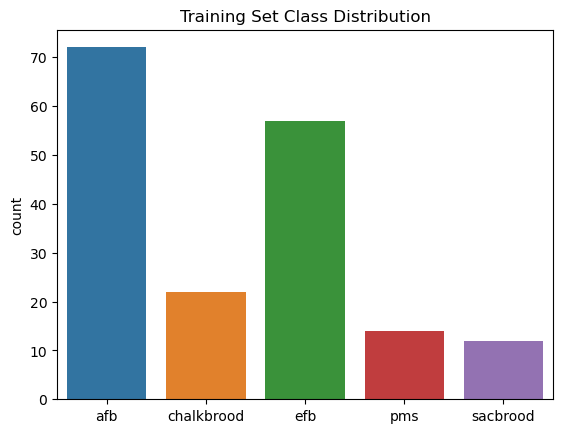

In [118]:
plt.title('Training Set Class Distribution')
sns.countplot(x=train_labels_unhealthy)
plt.xticks([0, 1, 2, 3, 4], ['afb', 'chalkbrood', 'efb', 'pms', 'sacbrood'])
plt.show()

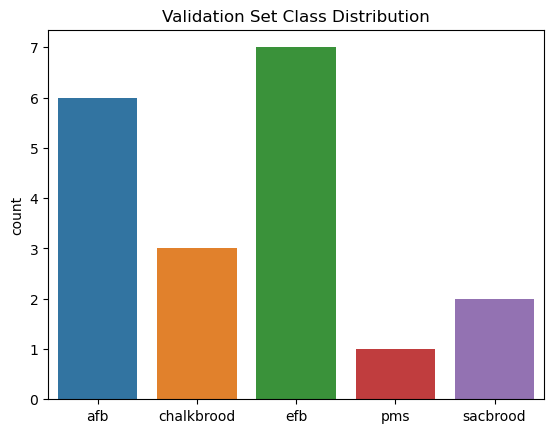

In [119]:
plt.title('Validation Set Class Distribution')
sns.countplot(x=val_labels_unhealthy)
plt.xticks([0, 1, 2, 3, 4], ['afb', 'chalkbrood', 'efb', 'pms', 'sacbrood'])
plt.show()

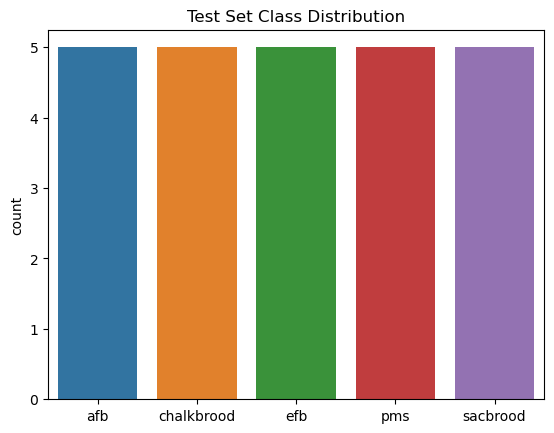

In [120]:
plt.title('Test Set Class Distribution')
sns.countplot(x=test_labels_unhealthy)
plt.xticks([0, 1, 2, 3, 4], ['afb', 'chalkbrood', 'efb', 'pms', 'sacbrood'])
plt.show()

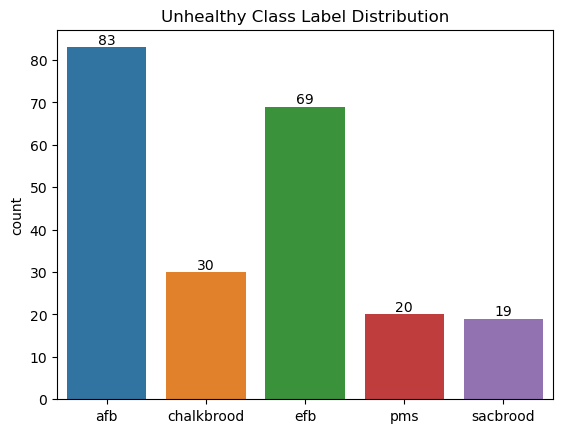

In [121]:
# Total class label distribution
Total_Unhealthy = train_labels_unhealthy + val_labels_unhealthy + test_labels_unhealthy
plt.title('Unhealthy Class Label Distribution')
fig=sns.countplot(x=Total_Unhealthy)
fig.bar_label(fig.containers[0])
plt.xticks([0, 1, 2, 3, 4], ['afb', 'chalkbrood', 'efb', 'pms', 'sacbrood'])
plt.show()

#### First CNN example

In [122]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal_and_vertical",
                                                        input_shape=(img_height,img_width,3)),
                                                        layers.RandomRotation(0.2),
                                                        layers.RandomZoom(0.2),
                                                        #layers.RandomContrast(0.2)
                                     ])

In [123]:
num_classes = len(class_names)

# Create CNN model
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  #layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  #layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Dropout(0.2),
    
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  #layers.GlobalMaxPooling2D(),
  layers.Dense(num_classes, activation = 'softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                 

In [124]:
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss',
                                  mode='min',
                                  patience=10)

In [125]:
epochs = 30
history = model.fit(train_ds_unhealthy, validation_data=val_ds_unhealthy, epochs=epochs, callbacks=[callback])

Epoch 1/30


2022-12-15 17:42:53.208962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 3s 273ms/step - loss: 3.9978 - accuracy: 0.2599 - val_loss: 1.7084 - val_accuracy: 0.3158
Epoch 2/30


2022-12-15 17:42:55.786527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 191ms/step - loss: 1.5982 - accuracy: 0.4068 - val_loss: 1.5570 - val_accuracy: 0.3158
Epoch 3/30
6/6 [==============================] - 1s 176ms/step - loss: 1.4732 - accuracy: 0.4068 - val_loss: 1.3716 - val_accuracy: 0.4211
Epoch 4/30
6/6 [==============================] - 1s 193ms/step - loss: 1.4039 - accuracy: 0.3672 - val_loss: 1.3749 - val_accuracy: 0.3158
Epoch 5/30
6/6 [==============================] - 1s 188ms/step - loss: 1.3763 - accuracy: 0.4068 - val_loss: 1.3089 - val_accuracy: 0.3158
Epoch 6/30
6/6 [==============================] - 1s 197ms/step - loss: 1.3524 - accuracy: 0.4124 - val_loss: 1.2964 - val_accuracy: 0.3158
Epoch 7/30
6/6 [==============================] - 1s 177ms/step - loss: 1.3307 - accuracy: 0.4068 - val_loss: 1.3132 - val_accuracy: 0.3158
Epoch 8/30
6/6 [==============================] - 1s 176ms/step - loss: 1.3252 - accuracy: 0.4124 - val_loss: 1.2556 - val_accuracy: 0.4737
Epoch 9/30
6/6 [===============

In [126]:
# View the Training and Validation Accuracy
def AccLossChart2():
    plt.figure(figsize=(8, 4.5))
    plt.subplot(1, 2, 1)
    plt.title("Accuracy vs Number of Epochs")
    losses = pd.DataFrame(history.history)
    plt.plot(losses['accuracy'], label='Training Accuracy')
    plt.plot(losses['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    #plt.ylim(0.4,1)
    plt.legend(loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.title("Loss for Training and Validation")
    losses = pd.DataFrame(history.history)
    plt.plot(losses['loss'], label='Training Loss')
    plt.plot(losses['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

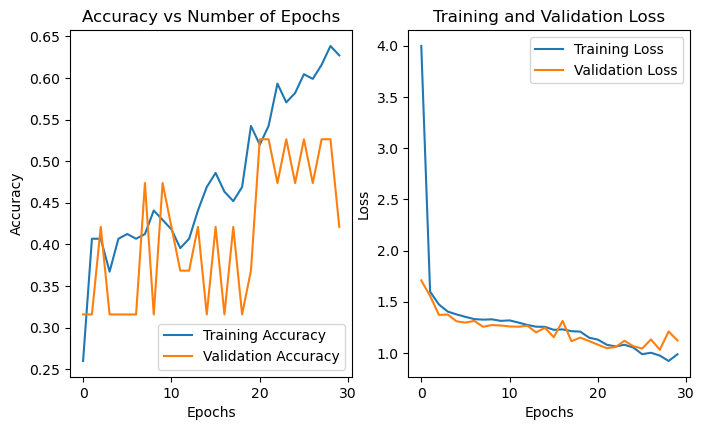

In [127]:
AccLossChart2()

In [128]:
val_loss, val_acc = model.evaluate(val_ds_unhealthy, verbose=2)

1/1 - 0s - loss: 1.1219 - accuracy: 0.4211 - 55ms/epoch - 55ms/step


In [129]:
test_loss, test_acc = model.evaluate(test_ds_unhealthy, verbose=2)

1/1 - 0s - loss: 2.2446 - accuracy: 0.2400 - 197ms/epoch - 197ms/step


In [130]:
# Try out the test set
test_labels=[]
y_pred = []

for images, labels in test_ds_unhealthy.unbatch():
    test_labels.append(int(np.array(labels)))
    img_array = tf.keras.utils.img_to_array(images)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    y_pred.append(np.argmax(predictions))

from sklearn.metrics import classification_report
Unhealthy_CNN1 = classification_report(test_labels, y_pred, target_names=class_names, output_dict=True)
print(classification_report(test_labels, y_pred, target_names=class_names))

1/1 [==============================] - 0s 10ms/step


2022-12-15 17:43:38.164642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

         afb       0.23      0.60      0.33         5
  chalkbrood       0.50      0.20      0.29         5
         efb       0.20      0.40      0.27         5
         pms       0.00      0.00      0.00         5
    sacbrood       0.00      0.00      0.00         5

    accuracy                           0.24        25
   macro avg       0.19      0.24      0.18        25
weighted avg       0.19      0.24      0.18        25



/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt

In [131]:
model.save('best_unhealthy_cnn_final_v2.h5')

This appears to be our best model. The performance is not overwhelmingly high; however, this was a risk with our smaller sample size. With more data, the results may be more promising.

#### Adjusting CNN and Using a Different Architecture

In [132]:
tf.keras.backend.clear_session()

# Set a random seed for reproducable results
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [133]:
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss',
                                  mode='min',
                                  patience=10)

In [134]:
num_classes = len(class_names)

# Create CNN model
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.GlobalMaxPooling2D(),
  layers.Dense(num_classes, activation = 'softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 32)      9248      
                                                        

In [135]:
epochs = 30
history = model.fit(train_ds_unhealthy, validation_data=val_ds_unhealthy, epochs=epochs, callbacks=[callback])

Epoch 1/30


2022-12-15 17:43:39.910797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.5343 - accuracy: 0.3446

2022-12-15 17:43:42.515364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 3s 347ms/step - loss: 1.5343 - accuracy: 0.3446 - val_loss: 1.4294 - val_accuracy: 0.3158
Epoch 2/30
6/6 [==============================] - 2s 242ms/step - loss: 1.3955 - accuracy: 0.4068 - val_loss: 1.4191 - val_accuracy: 0.3684
Epoch 3/30
6/6 [==============================] - 2s 241ms/step - loss: 1.4001 - accuracy: 0.2994 - val_loss: 1.4213 - val_accuracy: 0.3684
Epoch 4/30
6/6 [==============================] - 2s 267ms/step - loss: 1.3863 - accuracy: 0.3390 - val_loss: 1.4430 - val_accuracy: 0.3158
Epoch 5/30
6/6 [==============================] - 2s 227ms/step - loss: 1.3931 - accuracy: 0.4068 - val_loss: 1.4300 - val_accuracy: 0.3158
Epoch 6/30
6/6 [==============================] - 2s 233ms/step - loss: 1.3728 - accuracy: 0.4068 - val_loss: 1.4137 - val_accuracy: 0.3158
Epoch 7/30
6/6 [==============================] - 2s 230ms/step - loss: 1.3708 - accuracy: 0.4068 - val_loss: 1.4330 - val_accuracy: 0.3158
Epoch 8/30
6/6 [===============

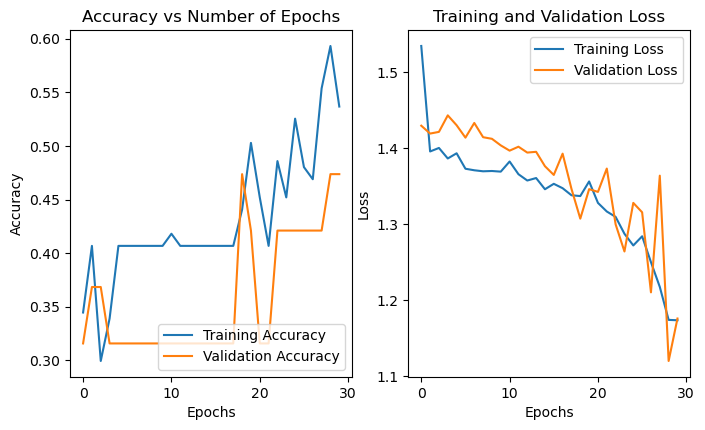

In [136]:
AccLossChart2()

In [137]:
# Try out the test set
test_labels=[]
y_pred = []

for images, labels in test_ds_unhealthy.unbatch():
    test_labels.append(int(np.array(labels)))
    img_array = tf.keras.utils.img_to_array(images)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    y_pred.append(np.argmax(predictions))

from sklearn.metrics import classification_report
Unhealthy_CNN6 = classification_report(test_labels, y_pred, target_names=class_names, output_dict=True)
print(classification_report(test_labels, y_pred, target_names=class_names))

1/1 [==============================] - 0s 11ms/step


2022-12-15 17:44:33.886922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

         afb       0.29      0.80      0.42         5
  chalkbrood       0.00      0.00      0.00         5
         efb       0.09      0.20      0.13         5
         pms       0.00      0.00      0.00         5
    sacbrood       0.00      0.00      0.00         5

    accuracy                           0.20        25
   macro avg       0.08      0.20      0.11        25
weighted avg       0.08      0.20      0.11        25



/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt

In [138]:
model.save('best_unhealthy_cnn_final_version.h5')

#### Transfer Learning

In [139]:
def TransferLearningMultiClass(model_name):
    if model_name == 'VGG16':
        img_height, img_width = 224,224 
        base = tf.keras.applications.VGG16(input_shape = (224,224,3), 
                                     include_top=False,
                                     weights='imagenet')
    elif model_name == 'EfficientNet':
        img_height, img_width = 224,224 
        base = tf.keras.applications.EfficientNetB0(input_shape = (224,224,3), 
                                     include_top=False,
                                     weights='imagenet')
    else:
        img_height, img_width = 224,224
        base = tf.keras.applications.ResNet50(input_shape = (224,224,3), 
                                     include_top=False,
                                     weights='imagenet')

    base.trainable = True

    # Freeze all the layers before a certain layer layer
    for layer in base.layers[:(round(len(base.layers) * (2/3)))]:
        base.trainable = False

    base.summary()
    
    train_ds_unhealthy = tf.keras.utils.image_dataset_from_directory(
      'Unhealthy_new',
      validation_split=0.1,
      subset="training",
      seed=123,
      label_mode='int',
      image_size=(img_height, img_width),
      batch_size=batch_size)

    val_ds_unhealthy = tf.keras.utils.image_dataset_from_directory(
      'Unhealthy_new',
      validation_split=0.1,
      subset="validation",
      seed=123,
      label_mode='int',
      image_size=(img_height, img_width),
      batch_size=batch_size)

    test_ds_unhealthy = tf.keras.utils.image_dataset_from_directory(
      'Unhealthy_TEST',
      #validation_split=0.1,
      #subset="training",
      seed=123,
      label_mode='int',
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
    data_augmentation = keras.Sequential([layers.RandomFlip("horizontal_and_vertical",
                                                        input_shape=(img_height,img_width,3)),
                                                        layers.RandomRotation(0.2),
                                                        layers.RandomZoom(0.2),
                                                        #layers.RandomContrast(0.1)
                                                        ])
    # Code inspiration: https://www.tensorflow.org/tutorials/images/transfer_learning
    resacle = tf.keras.layers.Rescaling(1./255.)
    glob_avg = tf.keras.layers.GlobalAveragePooling2D()
    prediction = tf.keras.layers.Dense(5, activation = 'softmax')
    
    inputs = tf.keras.Input(shape=(img_height,img_width,3))
    x = data_augmentation(inputs)
    x = resacle(x)
    x = base(x)
    x = glob_avg(x)
    outputs = prediction(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model, train_ds_unhealthy, val_ds_unhealthy, test_ds_unhealthy

#### VGG-16

In [140]:
model, train_ds_unhealthy, val_ds_unhealthy, test_ds_unhealthy = TransferLearningMultiClass('VGG16')

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [141]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [142]:
epochs = 30
history = model.fit(train_ds_unhealthy, validation_data=val_ds_unhealthy, epochs=epochs, callbacks=[callback])

Epoch 1/30


2022-12-15 17:44:35.828680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.6640 - accuracy: 0.1469

2022-12-15 17:44:39.024625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 4s 522ms/step - loss: 1.6640 - accuracy: 0.1469 - val_loss: 1.5662 - val_accuracy: 0.3684
Epoch 2/30
6/6 [==============================] - 3s 401ms/step - loss: 1.4625 - accuracy: 0.3559 - val_loss: 1.5027 - val_accuracy: 0.3158
Epoch 3/30
6/6 [==============================] - 3s 404ms/step - loss: 1.3912 - accuracy: 0.3842 - val_loss: 1.4979 - val_accuracy: 0.2632
Epoch 4/30
6/6 [==============================] - 3s 388ms/step - loss: 1.3720 - accuracy: 0.3785 - val_loss: 1.4923 - val_accuracy: 0.3158
Epoch 5/30
6/6 [==============================] - 3s 400ms/step - loss: 1.3602 - accuracy: 0.3898 - val_loss: 1.4690 - val_accuracy: 0.3158
Epoch 6/30
6/6 [==============================] - 3s 391ms/step - loss: 1.3320 - accuracy: 0.4181 - val_loss: 1.4312 - val_accuracy: 0.3158
Epoch 7/30
6/6 [==============================] - 3s 394ms/step - loss: 1.3273 - accuracy: 0.4124 - val_loss: 1.4032 - val_accuracy: 0.3158
Epoch 8/30
6/6 [===============

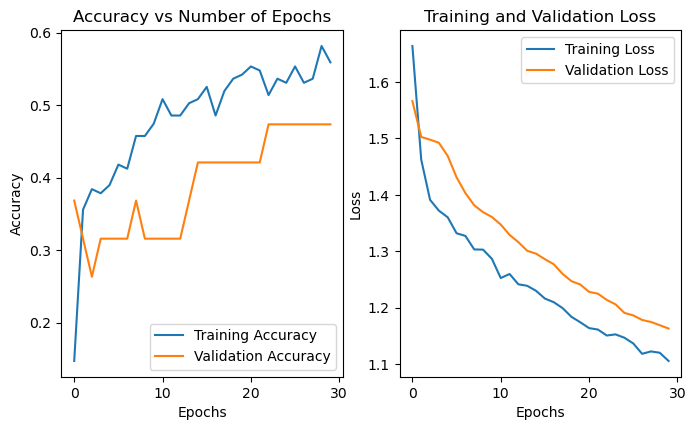

In [143]:
AccLossChart2()

In [144]:
model.evaluate(val_ds_unhealthy, verbose=True)

1/1 [==============================] - 0s 190ms/step - loss: 1.1631 - accuracy: 0.4737


[1.1630932092666626, 0.4736842215061188]

In [145]:
model.evaluate(test_ds_unhealthy, verbose=True)

1/1 [==============================] - 0s 431ms/step - loss: 1.9035 - accuracy: 0.2000


[1.90345299243927, 0.19999998807907104]

In [146]:
# Try out the test set
test_labels=[]
y_pred = []

for images, labels in test_ds_unhealthy.unbatch():
    test_labels.append(int(np.array(labels)))
    img_array = tf.keras.utils.img_to_array(images)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    y_pred.append(np.argmax(predictions))

from sklearn.metrics import classification_report
Unhealthy_CNN2 = classification_report(test_labels, y_pred, target_names=class_names, output_dict=True)
print(classification_report(test_labels, y_pred, target_names=class_names))

2022-12-15 17:45:57.509484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

         afb       0.23      1.00      0.37         5
  chalkbrood       0.00      0.00      0.00         5
         efb       0.00      0.00      0.00         5
         pms       0.00      0.00      0.00         5
    sacbrood       0.00      0.00      0.00         5

    accuracy                           0.20        25
   macro avg       0.05      0.20      0.07        25
weighted avg       0.05      0.20      0.07        25



/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt

#### EfficientNet

In [147]:
model, train_ds_unhealthy, val_ds_unhealthy, test_ds_unhealthy = TransferLearningMultiClass('EfficientNet')

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling_2[0][0]']            
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0

 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_e

 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )        

 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_s

 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_d

 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_e

 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
          

In [148]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [149]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 5)                 6405      
                                                           

In [150]:
epochs = 30
history = model.fit(
  train_ds_unhealthy,
  validation_data=val_ds_unhealthy,
  epochs=epochs,
  callbacks=[callback]
)

Epoch 1/30


2022-12-15 17:46:04.019840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.6027 - accuracy: 0.2542

2022-12-15 17:46:09.026029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 9s 863ms/step - loss: 1.6027 - accuracy: 0.2542 - val_loss: 1.4432 - val_accuracy: 0.3158
Epoch 2/30
6/6 [==============================] - 4s 368ms/step - loss: 1.3813 - accuracy: 0.3842 - val_loss: 1.5283 - val_accuracy: 0.3158
Epoch 3/30
6/6 [==============================] - 2s 249ms/step - loss: 1.4177 - accuracy: 0.4068 - val_loss: 1.4901 - val_accuracy: 0.3158
Epoch 4/30
6/6 [==============================] - 2s 237ms/step - loss: 1.4064 - accuracy: 0.4011 - val_loss: 1.4473 - val_accuracy: 0.3158
Epoch 5/30
6/6 [==============================] - 2s 237ms/step - loss: 1.3908 - accuracy: 0.3164 - val_loss: 1.4430 - val_accuracy: 0.3158
Epoch 6/30
6/6 [==============================] - 2s 302ms/step - loss: 1.3751 - accuracy: 0.4011 - val_loss: 1.4553 - val_accuracy: 0.3158
Epoch 7/30
6/6 [==============================] - 2s 227ms/step - loss: 1.3779 - accuracy: 0.4068 - val_loss: 1.4543 - val_accuracy: 0.3158
Epoch 8/30
6/6 [===============

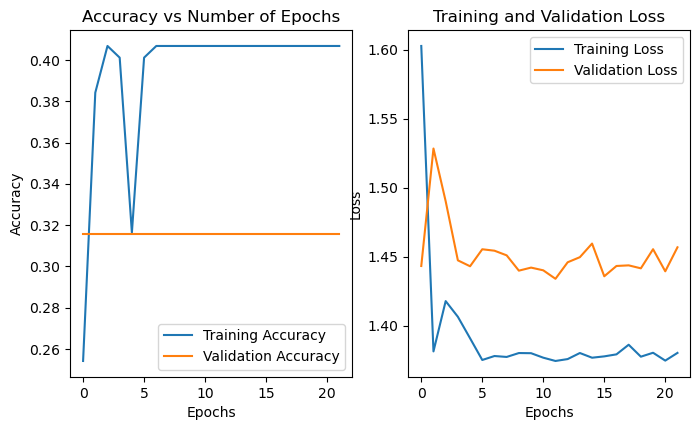

In [151]:
AccLossChart2()

In [152]:
model.evaluate(val_ds_unhealthy, verbose=True)

1/1 [==============================] - 0s 91ms/step - loss: 1.4567 - accuracy: 0.3158


[1.456744909286499, 0.31578946113586426]

In [153]:
model.evaluate(test_ds_unhealthy, verbose=True)

1/1 [==============================] - 1s 1s/step - loss: 1.8364 - accuracy: 0.2000


[1.8363981246948242, 0.19999998807907104]

In [154]:
# Try out the test set
test_labels=[]
y_pred = []

for images, labels in test_ds_unhealthy.unbatch():
    test_labels.append(int(np.array(labels)))
    img_array = tf.keras.utils.img_to_array(images)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    y_pred.append(np.argmax(predictions))

from sklearn.metrics import classification_report
Unhealthy_CNN3 = classification_report(test_labels, y_pred, target_names=class_names, output_dict=True)
print(classification_report(test_labels, y_pred, target_names=class_names))

2022-12-15 17:46:50.369059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 26ms/step
              precision    recall  f1-score   support

         afb       0.20      1.00      0.33         5
  chalkbrood       0.00      0.00      0.00         5
         efb       0.00      0.00      0.00         5
         pms       0.00      0.00      0.00         5
    sacbrood       0.00      0.00      0.00         5

    accuracy                           0.20        25
   macro avg       0.04      0.20      0.07        25
weighted avg       0.04      0.20      0.07        25



/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt

#### RestNet50

In [155]:
model, train_ds_unhealthy, val_ds_unhealthy, test_ds_unhealthy = TransferLearningMultiClass('ResNet50')

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [156]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [157]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 5)                 10245     
                                                           

In [158]:
epochs = 30
history = model.fit(
  train_ds_unhealthy,
  validation_data=val_ds_unhealthy,
  epochs=epochs,
  callbacks=[callback]
)

Epoch 1/30


2022-12-15 17:46:56.459115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.4875 - accuracy: 0.3616

2022-12-15 17:47:00.063414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 6s 665ms/step - loss: 1.4875 - accuracy: 0.3616 - val_loss: 1.4309 - val_accuracy: 0.3684
Epoch 2/30
6/6 [==============================] - 3s 312ms/step - loss: 1.3800 - accuracy: 0.3616 - val_loss: 1.4230 - val_accuracy: 0.3158
Epoch 3/30
6/6 [==============================] - 2s 281ms/step - loss: 1.3695 - accuracy: 0.4068 - val_loss: 1.4341 - val_accuracy: 0.3158
Epoch 4/30
6/6 [==============================] - 2s 284ms/step - loss: 1.3520 - accuracy: 0.4068 - val_loss: 1.3556 - val_accuracy: 0.3158
Epoch 5/30
6/6 [==============================] - 2s 291ms/step - loss: 1.3478 - accuracy: 0.3955 - val_loss: 1.3309 - val_accuracy: 0.4737
Epoch 6/30
6/6 [==============================] - 2s 267ms/step - loss: 1.3301 - accuracy: 0.4294 - val_loss: 1.3363 - val_accuracy: 0.3684
Epoch 7/30
6/6 [==============================] - 2s 292ms/step - loss: 1.3328 - accuracy: 0.4294 - val_loss: 1.3532 - val_accuracy: 0.3158
Epoch 8/30
6/6 [===============

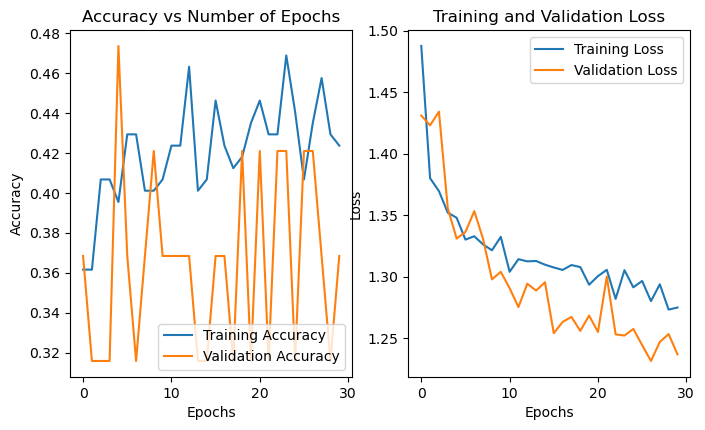

In [159]:
AccLossChart2()

In [160]:
model.evaluate(val_ds_unhealthy, verbose=True)

1/1 [==============================] - 0s 162ms/step - loss: 1.2368 - accuracy: 0.3684


[1.236761212348938, 0.3684210479259491]

In [161]:
model.evaluate(test_ds_unhealthy, verbose=True)

1/1 [==============================] - 1s 749ms/step - loss: 2.0968 - accuracy: 0.1600


[2.0968239307403564, 0.1599999964237213]

In [162]:
# Try out the test set
test_labels=[]
y_pred = []

for images, labels in test_ds_unhealthy.unbatch():
    test_labels.append(int(np.array(labels)))
    img_array = tf.keras.utils.img_to_array(images)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    y_pred.append(np.argmax(predictions))

from sklearn.metrics import classification_report
Unhealthy_CNN5 = classification_report(test_labels, y_pred, target_names=class_names, output_dict=True)
print(classification_report(test_labels, y_pred, target_names=class_names))

2022-12-15 17:48:01.097706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

         afb       0.17      0.80      0.28         5
  chalkbrood       0.00      0.00      0.00         5
         efb       0.00      0.00      0.00         5
         pms       0.00      0.00      0.00         5
    sacbrood       0.00      0.00      0.00         5

    accuracy                           0.16        25
   macro avg       0.03      0.16      0.06        25
weighted avg       0.03      0.16      0.06        25



/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt

We can see that the performace is much lower for all of the models trying to predict which class the diseased images belong to. This is likely due to our smaller sample size and the 5 different classes trying to be predicted. With more data, I am hopeful that the results would improve and the model would generalize better.